<a href="https://colab.research.google.com/github/Elman295/Stack_overflow_classification/blob/main/Stack_overflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#`multi-class classification on Stack Overflow questions`

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on BigQuery, which contains more than 17 million posts.

train/ <br/>
..python/<br/>
........0.txt<br/>
........1.txt<br/>
..javascript/<br/>
........0.txt<br/>
........1.txt<br>
..csharp/,<br/>
........0.txt<br/>
........1.txt<br/>
..java/<br/>
........0.txt<br/>
........1.txt<br/>


In [30]:
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt
import numpy
%matplotlib inline

#`preparing the data`

In [8]:
with zipfile.ZipFile("stack_overflow_16k.zip","r") as f:
  f.extractall("data")

In [13]:
data = os.path.join("data","/content/data/stack_overflow_16k")
os.listdir(data)

['train', 'README.md', 'test']

In [14]:
train_dir = os.path.join(data, "train")
os.listdir(train_dir)

['java', 'javascript', 'csharp', 'python']

In [15]:
test_dir = os.path.join(data, "test")
os.listdir(test_dir)

['java', 'javascript', 'csharp', 'python']

In [16]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    directory = train_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 32,
    batch_size = 32
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [33]:
for text, labels in raw_train_ds.take(1):
  for i in range(10):
    print(text.numpy()[i])
    print(labels.numpy()[i])

b'"overwrite global variables i have two modules:..constants.py..def define_sizes(supersample):    .    global supersample.    global width.    global height.    global line_width..    supersample = supersample.    width = 1280*supersample.    height = 854*supersample.    line_width = 1*supersample..define_sizes(1)...test.py..from constants import *...print(width, height, line_width).# draw something..define_sizes(4)..print(width, height, line_width).# draw the same thing, but bigger...the result is:..1280 854 1.1280 854 1...i would expect to get:..1280 854 1.5120 3416 4...why is that? what am i missing? can i fix it to give expected results?"\n'
3
b'"blank - recursively create a nested dictionary from a list of other dictionaries i have the following list: ..[.{(\'pct\',): ([], \'0.750000008089\')}, .{(u\'gp\',): (\'balance\', \'\')}, .{(u\'uk\', u\'uz\', u\'uf\', u\'us\', u\'zu\'): ([], \'\')}, .{(u\'uk\', u\'uz\'): (\'balance\', \'\')}, .{(u\'uf\', u\'us\', u\'zu\'): ([], \'\')}, .{

In [34]:
print(f"0 is for {raw_train_ds.class_names[0]}")
print(f"1 is for {raw_train_ds.class_names[1]}")
print(f"2 is for {raw_train_ds.class_names[2]}")
print(f"3 is for {raw_train_ds.class_names[3]}")


0 is for csharp
1 is for java
2 is for javascript
3 is for python


In [17]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    directory = train_dir,
    validation_split = 0.2,
    subset = "validation",
    batch_size = 32,
    seed = 32
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [18]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    directory = test_dir,
    seed = 32,
    batch_size = 32
)

Found 8000 files belonging to 4 classes.


In [20]:
max_tokens = 10000
vectorized_layer = tf.keras.layers.TextVectorization(
    max_tokens = max_tokens,
    output_sequence_length = 250
)

train = raw_train_ds.map(lambda x,y : x)
vectorized_layer.adapt(train)

In [21]:
def vectorized_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorized_layer(text), label

In [22]:
train_ds = raw_train_ds.map(vectorized_text)
val_ds = raw_val_ds.map(vectorized_text)
test_ds = raw_test_ds.map(vectorized_text)

#`Defining the model`

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_tokens+1, 16),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 4)
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
__________________________________________________

In [25]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

#`Fitting the model`

In [26]:
model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = ["accuracy"]
)

In [27]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 20
)

Epoch 1/20
200/200 [==============================] - 4s 18ms/step - loss: 1.3801 - accuracy: 0.3341 - val_loss: 1.3701 - val_accuracy: 0.3819
Epoch 2/20
200/200 [==============================] - 4s 18ms/step - loss: 1.3518 - accuracy: 0.4916 - val_loss: 1.3311 - val_accuracy: 0.5612
Epoch 3/20
200/200 [==============================] - 3s 17ms/step - loss: 1.2980 - accuracy: 0.5458 - val_loss: 1.2713 - val_accuracy: 0.5969
Epoch 4/20
200/200 [==============================] - 3s 17ms/step - loss: 1.2267 - accuracy: 0.5880 - val_loss: 1.1990 - val_accuracy: 0.6244
Epoch 5/20
200/200 [==============================] - 4s 17ms/step - loss: 1.1481 - accuracy: 0.6370 - val_loss: 1.1252 - val_accuracy: 0.6669
Epoch 6/20
200/200 [==============================] - 3s 17ms/step - loss: 1.0695 - accuracy: 0.6783 - val_loss: 1.0573 - val_accuracy: 0.6950
Epoch 7/20
200/200 [==============================] - 4s 18ms/step - loss: 0.9978 - accuracy: 0.7144 - val_loss: 0.9941 - val_accuracy: 0.7119

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

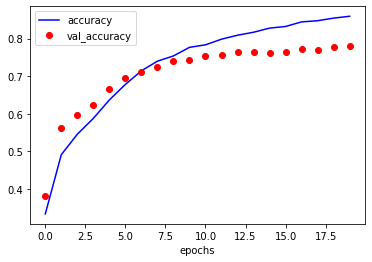

In [41]:
plt.plot(history.history["accuracy"], color = "blue", label = "accuracy")
plt.plot(history.history["val_accuracy"], "ro", label ="val_accuracy")
plt.xlabel("epochs")
plt.legend()
plt.show()

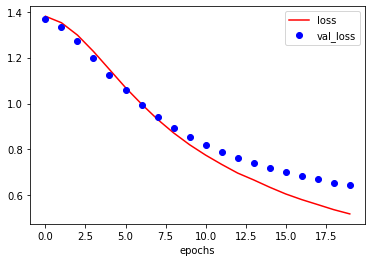

In [42]:
plt.plot(history.history["loss"], color = "red", label = "loss")
plt.plot(history.history["val_loss"], "bo", label = "val_loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [44]:
loss, accuracy = model.evaluate(test_ds)
print(f"loss is {loss}")
print(f"accuracy is {accuracy} ")

250/250 [==============================] - 3s 11ms/step - loss: 0.6385 - accuracy: 0.7805
loss is 0.6384689807891846
accuracy is 0.7804999947547913 


In [43]:
model.save("txt.h5")